<div align="center">
    <h1><b>Reinforcement Learning Assignment</b></h1>
</div>

## Introduction
This notebook is part of an assignment for the course **'Reinforcement Learning & Stochastic Games'** of the **[Department of Informatics and Telecommunications](https://www.di.uoa.gr/)** at the **National and Kapodistrian University of Athens (NKUA)**.

### Purpose
The purpose of this assignment is to **experiment** with various **machine learning algorithms**, in order to train a model on a specific **environment** from **[OpenAI Gym or Gymnasium](https://www.gymlibrary.dev/index.html)**.

### Team Members
The members who contributed to this assignment are as follows:

| First Name | Last Name | Student ID | Email |
| :---: | :---: | :---: | :---: |
| Antonis | Zikas | 1115202100038 | sdi2100038@di.uoa.gr |
| Panagiotis | Papapostolou | 1115202100142 | sdi2100142@di.uoa.gr |

## Environment Selection and Analysis
In this assignment, we chose to work with the **[CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)** environment, which belongs to the **[Classic Control](https://www.gymlibrary.dev/environments/classic_control/)** category.

<div align="center">
<img src="../assets/imgs/cart-pole-diagram.png" width="500px">    
</div>

Let's analyze this environment.

### Action Space
For this specific environment, there are **two possible actions**. Specifically, the **cart** can move either **left** or **right**. These actions are represented by **0** and **1** respectively and are described in the table below:

| Number | Action |
| :---: | :---: |
| 0 | Move left |
| 1 | Move right |

Therefore, the **action** of this environment is an `ndarray` of shape `(1,)` and can take two values `{0, 1}`.

### Observation Space
The **observation space** for this environment is a collection of **4** values:
1. The **position** of the cart **(Cart Position)**
2. The **velocity** of the cart **(Cart Velocity)**
3. The **angle** formed by the pole with the vertical axis **(Pole Angle)**
4. The **angular velocity** of the pole as it falls **(Pole Angular Velocity)**

These values are stored in an `ndarray` of shape `(4,)` and each value has specific limits, described below:

| Array index | Observation | Min Value | Max Value |
| :---: | :---: | :---: | :---: |
| 0 | Cart Position | $-4.8$ | $4.8$ |
| 1 | Cart Velocity | $-\infty$ | $+\infty$ |
| 2 | Pole Angle | ~ $-0.418$ rad (-$24^{\circ}$) | ~ $0.418$ rad ($24^{\circ}$) |
| 3 | Pole Angular Velocity | $-\infty$ | $+\infty$ |

### Reward
For each step during the training of the model, the **reward** received by the selected **agent** is `+1`, including the **termination step**. The **reward threshold** for this environment is **500**.

## Environment Default Run

### Loading the environment

In [25]:
import gymnasium as gym

env = gym.make('CartPole-v1')
observations = env.observation_space.shape[0]
actions = env.action_space.n

print(f"Observations: {observations}, Actions: {actions}")
env.close()

Observations: 4, Actions: 2


As we observe from the above code execution, the **observations** and **actions** are indeed **4** and **2** respectively. Let’s try running this environment **without** any trained model and observe the results.

### Running

In [26]:
# Define the number of epochs and initialize scores
epochs = 200
epochs_scores = []
wins, fails = 0, 0

# Run the environment for the specified number of epochs
env = gym.make('CartPole-v1')
for epoch in range(1, epochs+1):
    env.reset()
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = env.action_space.sample() # Chose a random action from 0 and 1
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        # Check if the episode is done, either by termination or truncation
        if terminated or truncated:
            observation, _ = env.reset()
            done = True

            # Count wins and fails based on the episode outcome
            if terminated and total_steps < epochs:
                fails += 1
            else:
                wins +=1
    
    epochs_scores.append(score)

env.close()
default_scores = epochs_scores
default_wins, default_fails = wins, fails

### Visualizing the results
Let’s visualize the total **score** achieved by our environment for each **epoch**, as well as the number of successes and failures recorded.

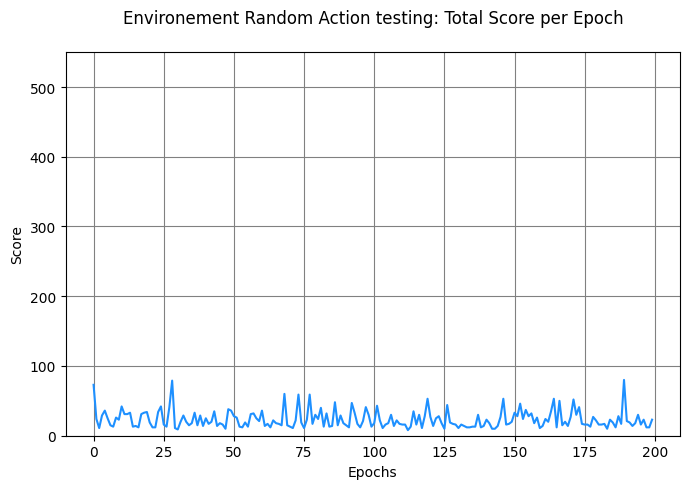

Number of wins: 0
Number of fails: 200


In [27]:
import matplotlib.pyplot as plt

plt.style.use('default')
plots_save_path = '../reports/figs/'

figure, axis = plt.subplots(1, 1, figsize=(7, 5))
axis.plot(epochs_scores, color='dodgerblue')
axis.set_ylim(0, 550)
axis.set_title("Environement Random Action testing: Total Score per Epoch\n")
axis.set_xlabel("Epochs")
axis.set_ylabel("Score")
axis.grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'default_scores.png')
plt.show()

print(f'Number of wins: {default_wins}')
print(f'Number of fails: {default_fails}')

From the above diagram, we observe that the total **score** achieved by the environment is very low. Our goal, therefore, is to **train** a model so that we manage to increase the **score** up to the corresponding **threshold** of the environment, which is **500**.

## Implementation of the DQN (Deep Q-Network) Algorithm

We will start by implementing the **[DQN](https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae)** algorithm, which will be used to train our model. This algorithm requires the use of a **neural network**, for which we will use the **[PyTorch](https://pytorch.org/)** package.

<!-- <div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:2400/format:webp/1*aqNgmfyBIStLrf9k7d9cng.jpeg" width="500px">
</div> -->

### Connect to device

In [28]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cpu


### Setting random seed

In [29]:
import random
import torch
import numpy as np
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        try:
            torch.use_deterministic_algorithms(True)
        except RuntimeError:
            print("Warning: Could not enable deterministic algorithms in torch.")

        os.environ['PYTHONHASHSEED'] = str(seed)

### Building the Neural Network
Let’s start with building the **neural network**. The **architecture** of the network will be as follows:
1. **Input Layer** with **4 nodes** (number of observations)
2. **Hidden Layer 1** with **128 nodes**
3. **Hidden Layer 2** with **128 nodes**
4. **Output Layer** with **2 nodes** (number of actions)

In [30]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F


class DeepQNetwork_CartPole(nn.Module):
    def __init__(self, input_dims: int, output_dims: int) -> None:
        super(DeepQNetwork_CartPole, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.fc1 = nn.Linear(self.input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, self.output_dims)
          

    def forward(self, state: T.Tensor) -> T.Tensor:
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions = self.fc4(x)

        return actions


### Creating the Replay Buffer

In [31]:
import numpy as np
from collections import deque
import torch as T


class ReplayBufferMemory:
    def __init__(self, capacity=10000, device='cpu'):
        self.device = device
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = np.random.choice(len(self.memory), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in batch])
        return (
            T.Tensor(np.array(states)).to(self.device),
            T.LongTensor(np.array(actions)).to(self.device),
            T.Tensor(np.array(rewards)).to(self.device),
            T.Tensor(np.array(next_states)).to(self.device),
            T.Tensor(np.array(dones)).to(self.device)
        )
    
    def __len__(self):
        return len(self.memory)


### Implementing the Agent

In [32]:
import torch as T
import torch.nn as nn
import numpy as np


class Agent():
    def __init__(
            self, gamma, epsilon, epsilon_min, epsilon_decay, lr, input_dims, n_actions, taget_update_freq, 
            memory_size, batch_size, network, device
        ):
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.input_dims = input_dims
        self.n_actions = n_actions
        self.device = device

        self.action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.target_update_freq = taget_update_freq
        self.memory_size = memory_size

        # Initialize the Deep Q-Networks and send to device
        self.policy_network = network(input_dims, n_actions).to(self.device)
        self.target_network = network(input_dims, n_actions).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        self.learning_rate = lr
        self.optimizer = T.optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.memory_buffer = ReplayBufferMemory(capacity=self.memory_size, device=self.device)

        self.steps_done = 0  # Track total steps globally

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            state = T.tensor(np.array([observation]), dtype=T.float32).to(self.device)
            with T.no_grad():
                actions = self.policy_network(state)
            best_action = T.argmax(actions).item()
            return best_action

    def optimize(self):
        if len(self.memory_buffer) <= self.batch_size:
            return

        # Sample batch from replay buffer. Batch tensors are already on the appropriate device via ReplayBufferMemory.sample
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory_buffer.sample(self.batch_size)

        # Compute current Q values
        q_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

        # Compute target Q values using target network
        with T.no_grad():
            max_next_q_values = self.target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + self.gamma * max_next_q_values * (1 - done_batch)

        # Calculate loss
        loss = nn.MSELoss()(q_values, target_q_values)

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


### Initializing the trainer

In [33]:
class Trainer():
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env

    def train_agent(self, num_episodes=100, seed=42, printing=True):
        set_seed(seed)

        score_per_episode = []
        loss_per_episode = []
        epsilon_per_episode = []

        for episode in range(num_episodes):
            observation, info = self.env.reset(seed=seed if episode == 0 else None)
            episode_score, episode_loss = 0, 0
            done = False

            while not done:
                action = self.agent.choose_action(observation)
                next_observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                self.agent.memory_buffer.add(observation, action, reward, next_observation, float(done))

                observation = next_observation
                episode_score += reward

                loss = self.agent.optimize()
                if loss is not None:
                    episode_loss += loss

                self.agent.steps_done += 1

            epsilon_per_episode.append(self.agent.epsilon)
            score_per_episode.append(episode_score)
            loss_per_episode.append(episode_loss)

            if episode % self.agent.target_update_freq == 0:
                self.agent.target_network.load_state_dict(self.agent.policy_network.state_dict())
                
            self.agent.decay_epsilon()

            # Logging progress every ~10% of total episodes
            if printing:
                if episode == 0 or episode == num_episodes - 1 or episode % max(1, num_episodes // 10) == 0:
                    if episode == 0 or episode == num_episodes - 1: print(f'Episode {episode+1}:', end=' ')
                    else: print(f'Episode {episode}: ', end=' ')
                    print(f"Score: {episode_score}, Epsilon: {self.agent.epsilon:.2f}")

        return {
            "scores": score_per_episode, 
            "losses": loss_per_episode, 
            "epsilons": epsilon_per_episode
        }


### Training the agent

In [34]:
# Hyperparameters
GAMMA = 0.99          # Discount factor
LR = 1e-3             # Learning rate
BATCH_SIZE = 64       # Minibatch size
MEMORY_SIZE = 10000   # Replay buffer size
EPSILON_START = 1.0   # Starting exploration probability
EPSILON_END = 0.01    # Minimum exploration probability
EPSILON_DECAY = 0.995 # Epsilon decay rate
TARGET_UPDATE = 10    # How often to update the target network

In [35]:
agent = Agent(
    GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR, observations, actions, TARGET_UPDATE, 
    MEMORY_SIZE, BATCH_SIZE, DeepQNetwork_CartPole, device
)
trainer = Trainer(agent, env)

results = trainer.train_agent(500)

env.close()

# Save the trained model
T.save(agent.policy_network.state_dict(), '../models/dqn_model.pth')

Episode 1: Score: 28.0, Epsilon: 0.99
Episode 50:  Score: 30.0, Epsilon: 0.77
Episode 100:  Score: 21.0, Epsilon: 0.60
Episode 150:  Score: 13.0, Epsilon: 0.47
Episode 200:  Score: 364.0, Epsilon: 0.37
Episode 250:  Score: 127.0, Epsilon: 0.28
Episode 300:  Score: 345.0, Epsilon: 0.22
Episode 350:  Score: 500.0, Epsilon: 0.17
Episode 400:  Score: 79.0, Epsilon: 0.13
Episode 450:  Score: 176.0, Epsilon: 0.10
Episode 500: Score: 292.0, Epsilon: 0.08


### Visualizing the results

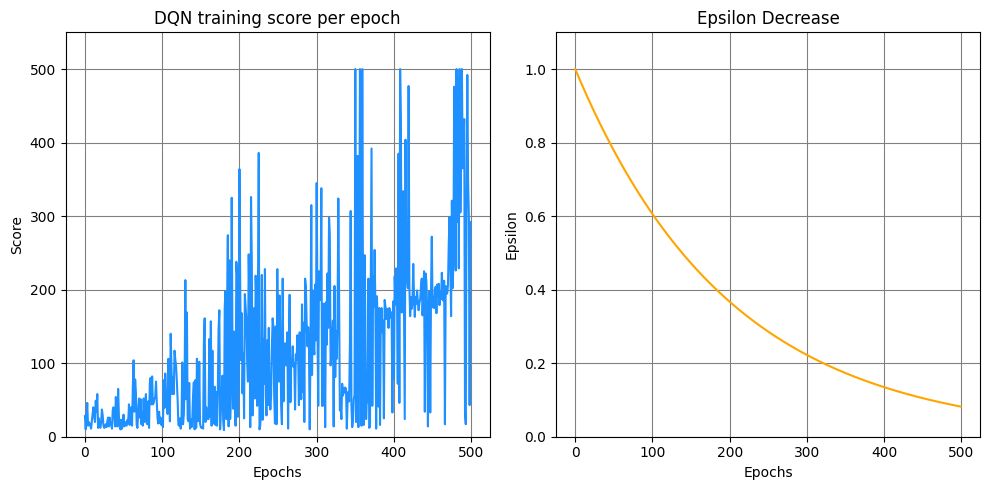

In [36]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(results['scores'], color='dodgerblue')
axis[0].set_ylim(0, 550)
axis[0].set_title("DQN training score per epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].grid(color='grey')

axis[1].plot(results['epsilons'], color='orange')
axis[1].set_title("Epsilon Decrease")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Epsilon")
axis[1].set_ylim(0, 1.1)
axis[1].grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_training_results.png')
plt.show()

### Testing the trained model and compare the results

In [37]:
# Load the trained model for testing
model = T.load('../models/dqn_model.pth')
agent.policy_network.load_state_dict(model)
agent.policy_network.eval()

# Testing the trained model
test_epochs = 200
test_epochs_scores = []
wins, fails = 0, 0

set_seed(42)

env = gym.make('CartPole-v1')
for epoch in range(1, test_epochs+1):
    env.reset(seed=42 if epoch == 1 else None)
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = agent.choose_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        if terminated or truncated:
            observation, _ = env.reset(seed=42 if epoch == 1 else None)
            done = True

            if terminated and total_steps < test_epochs:
                fails += 1
            else:
                wins +=1
    
    test_epochs_scores.append(score)

env.close()

dqn_scores = test_epochs_scores
dqn_wins, dqn_fails = wins, fails

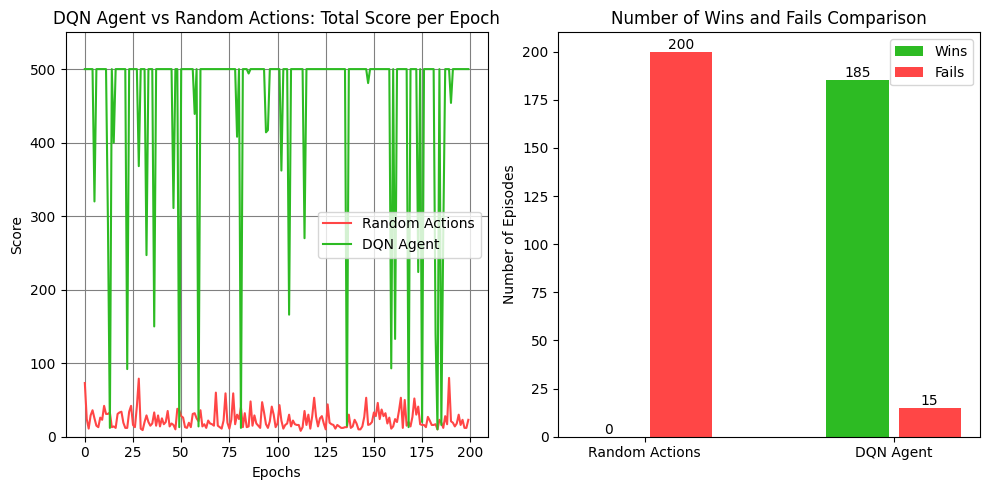

Number of wins with DQN Agent: 185
Number of fails with DQN Agent: 15


In [38]:
# Comparing the results between random actions and DQN agent
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(default_scores, label='Random Actions', color='#FF4646')
axis[0].plot(test_epochs_scores, label='DQN Agent', color='#2DBB23')

axis[0].set_ylim(0, 550)
axis[0].set_title("DQN Agent vs Random Actions: Total Score per Epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].legend()
axis[0].grid(color='grey')

categories = ['Random Actions', 'DQN Agent']
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
gap = 0.02

wins_values = [default_wins, dqn_wins]
fails_values = [default_fails, dqn_fails]

bars_wins = axis[1].bar(x - width/2 - gap, wins_values, width, label='Wins', color=["#2DBB23", '#2DBB23'])
bars_fails = axis[1].bar(x + width/2 + gap, fails_values, width, label='Fails', color=['#FF4646', '#FF4646'])

axis[1].set_title("Number of Wins and Fails Comparison")
axis[1].set_ylabel("Number of Episodes")
axis[1].set_xticks(x)
axis[1].set_xticklabels(categories)
axis[1].legend()

# Adding labels on top of the bars
for bar in bars_wins:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars_fails:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_vs_random.png')
plt.show()

print(f'Number of wins with DQN Agent: {dqn_wins}')
print(f'Number of fails with DQN Agent: {dqn_fails}')

### Sensitivity Study

1. Learning Rate ($\alpha$)
2. Discount Factor ($\gamma$)
3. Replay Buffer Size
4. Batch Size

In [39]:
def run_sensitivity_study(experiments_params=None, network=DeepQNetwork_CartPole):
    results = {}

    for param, values in experiments_params.items():
        
        results[param] = {}
        print(f"\n--- Sensitivity Study: Varying {param} ---")

        for value in values:
            print(f"Running experiment with {param} = {value}")
            if param == "lr":
                agent = Agent(
                    gamma=0.99, epsilon=1.0, lr=value, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, network=network, device=device                
                )
            elif param == "gamma":
                agent = Agent(
                    gamma=value, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=BATCH_SIZE, network=network, device=device                
                )
            elif param == "replay_buffer_size":
                agent = Agent(
                    gamma=0.99, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=value, batch_size=BATCH_SIZE, network=network, device=device                
                )
                agent.memory_size = value
                agent.memory_buffer = ReplayBufferMemory(capacity=value, device=device)
            elif param == "batch_size":
                agent = Agent(
                    gamma=0.99, epsilon=1.0, lr=0.001, input_dims=4, n_actions=2,
                    epsilon_min=EPSILON_END, epsilon_decay=EPSILON_DECAY, taget_update_freq=TARGET_UPDATE,
                    memory_size=MEMORY_SIZE, batch_size=value, network=network, device=device                
                )
                agent.batch_size = value

            trainer = Trainer(agent, env)
            results[param][value] = trainer.train_agent(num_episodes=100, printing=False)
    
    return results

In [40]:
experiments_params = {
    "lr": [1e-4, 5e-4, 1e-3, 5e-3],
    "gamma": [0.8, 0.9, 0.99, 0.999],
    "replay_buffer_size": [1000, 5000, 10000, 50000],
    "batch_size": [32, 64, 128, 256]
}

sensitivity_study_results = run_sensitivity_study(experiments_params, DeepQNetwork_CartPole)


--- Sensitivity Study: Varying lr ---
Running experiment with lr = 0.0001
Running experiment with lr = 0.0005
Running experiment with lr = 0.001
Running experiment with lr = 0.005

--- Sensitivity Study: Varying gamma ---
Running experiment with gamma = 0.8
Running experiment with gamma = 0.9
Running experiment with gamma = 0.99
Running experiment with gamma = 0.999

--- Sensitivity Study: Varying replay_buffer_size ---
Running experiment with replay_buffer_size = 1000
Running experiment with replay_buffer_size = 5000
Running experiment with replay_buffer_size = 10000
Running experiment with replay_buffer_size = 50000

--- Sensitivity Study: Varying batch_size ---
Running experiment with batch_size = 32
Running experiment with batch_size = 64
Running experiment with batch_size = 128
Running experiment with batch_size = 256


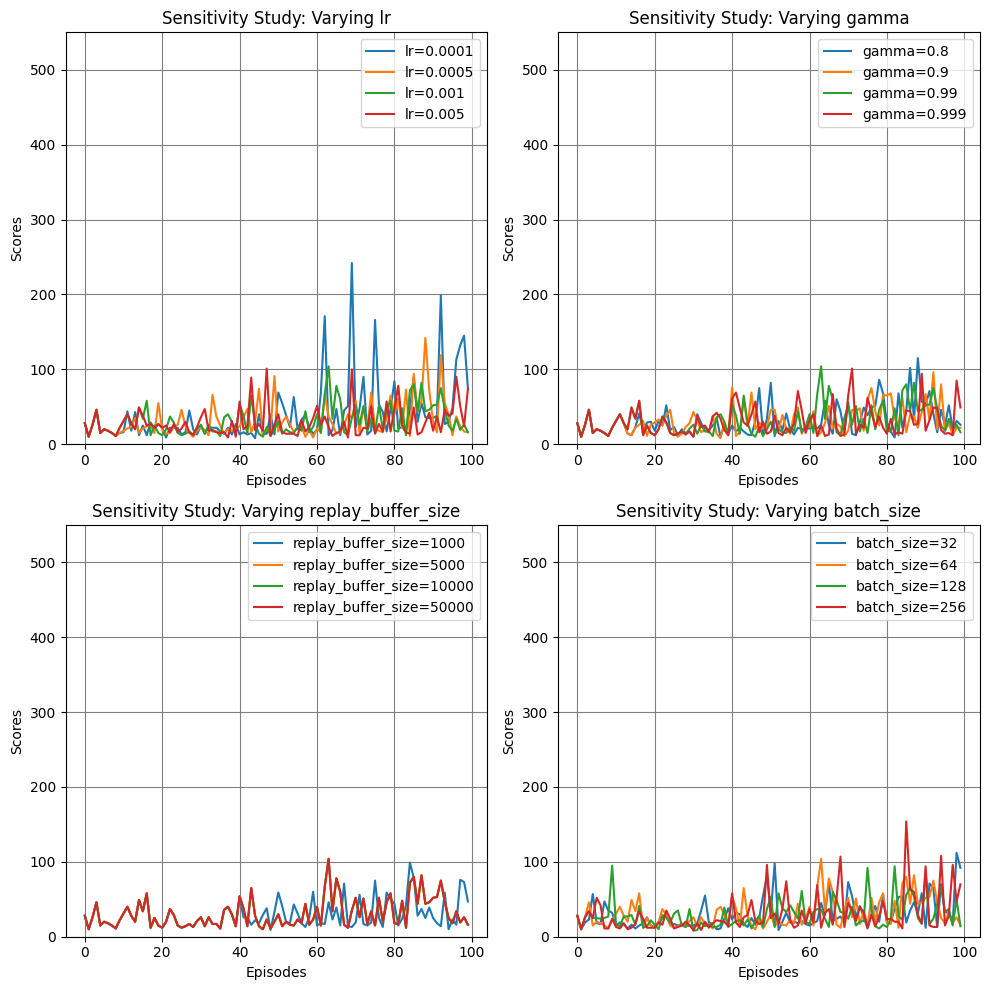

In [41]:
# Plot the sensitivity study results in a grid of 8x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (param, experiments) in enumerate(sensitivity_study_results.items()):
    for value, result in experiments.items():
        axes[idx].plot(result['scores'], label=f'{param}={value}')
    
    axes[idx].set_title(f'Sensitivity Study: Varying {param}')
    axes[idx].set_xlabel('Episodes')
    axes[idx].set_ylabel('Scores')
    axes[idx].set_ylim(0, 550)
    axes[idx].legend()
    axes[idx].grid(color='grey')

# Hide any unused subplots
for i in range(len(sensitivity_study_results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(plots_save_path + 'sensitivity_study.png')
plt.show()

### Dueling Architecture

In [42]:
class DuelingArchitectureNetwork(nn.Module):
    def __init__(self, input_dims: int, output_dims: int) -> None:
        super(DuelingArchitectureNetwork, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.fc1 = nn.Linear(self.input_dims, 128)
        self.fc2 = nn.Linear(128, 128)

        # Value and Advantage streams
        self.value_stream_fc = nn.Linear(128, 64)
        self.value_stream = nn.Linear(64, 1)

        self.advantage_stream_fc = nn.Linear(128, 64)
        self.advantage_stream = nn.Linear(64, self.output_dims)
          

    def forward(self, state: T.Tensor) -> T.Tensor:
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        v = F.relu(self.value_stream_fc(x))
        v = self.value_stream(v)

        a = F.relu(self.advantage_stream_fc(x))
        a = self.advantage_stream(a)

        actions = v + (a - a.mean(dim=1, keepdim=True))

        return actions


In [43]:
agent = Agent(
    GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, LR, observations, actions, TARGET_UPDATE, 
    MEMORY_SIZE, BATCH_SIZE, DuelingArchitectureNetwork, device
)
trainer = Trainer(agent, env)

results = trainer.train_agent(500)

env.close()

# Save the trained model
T.save(agent.policy_network.state_dict(), '../models/dueling_arc_dqn_model.pth')

Episode 1: Score: 28.0, Epsilon: 0.99
Episode 50:  Score: 10.0, Epsilon: 0.77
Episode 100:  Score: 59.0, Epsilon: 0.60
Episode 150:  Score: 56.0, Epsilon: 0.47
Episode 200:  Score: 27.0, Epsilon: 0.37
Episode 250:  Score: 75.0, Epsilon: 0.28
Episode 300:  Score: 124.0, Epsilon: 0.22
Episode 350:  Score: 143.0, Epsilon: 0.17
Episode 400:  Score: 130.0, Epsilon: 0.13
Episode 450:  Score: 110.0, Epsilon: 0.10
Episode 500: Score: 500.0, Epsilon: 0.08


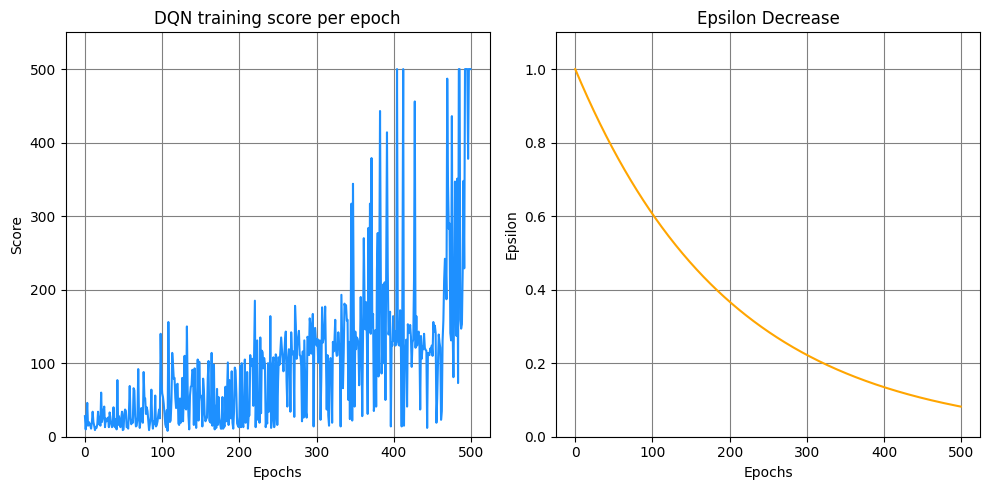

In [44]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(results['scores'], color='dodgerblue')
axis[0].set_ylim(0, 550)
axis[0].set_title("DQN training score per epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].grid(color='grey')

axis[1].plot(results['epsilons'], color='orange')
axis[1].set_title("Epsilon Decrease")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Epsilon")
axis[1].set_ylim(0, 1.1)
axis[1].grid(color='grey')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_training_results.png')
plt.show()

In [45]:
# Load the trained model for testing
model = T.load('../models/dueling_arc_dqn_model.pth')
agent.policy_network.load_state_dict(model)
agent.policy_network.eval()

# Testing the trained model
test_epochs = 200
test_epochs_scores = []
wins, fails = 0, 0

set_seed(42)

env = gym.make('CartPole-v1')
for epoch in range(1, test_epochs+1):
    env.reset(seed=42 if epoch == 1 else None)
    done = False
    score, total_steps = 0, 0
    
    while not done:
        action = agent.choose_action(observation)
        observation, reward, terminated, truncated, _ = env.step(action)
        score += reward
        total_steps += 1
        
        if terminated or truncated:
            observation, _ = env.reset(seed=42 if epoch == 1 else None)
            done = True

            if terminated and total_steps < test_epochs:
                fails += 1
            else:
                wins +=1
    
    test_epochs_scores.append(score)

env.close()

dqn_scores = test_epochs_scores
dqn_wins, dqn_fails = wins, fails

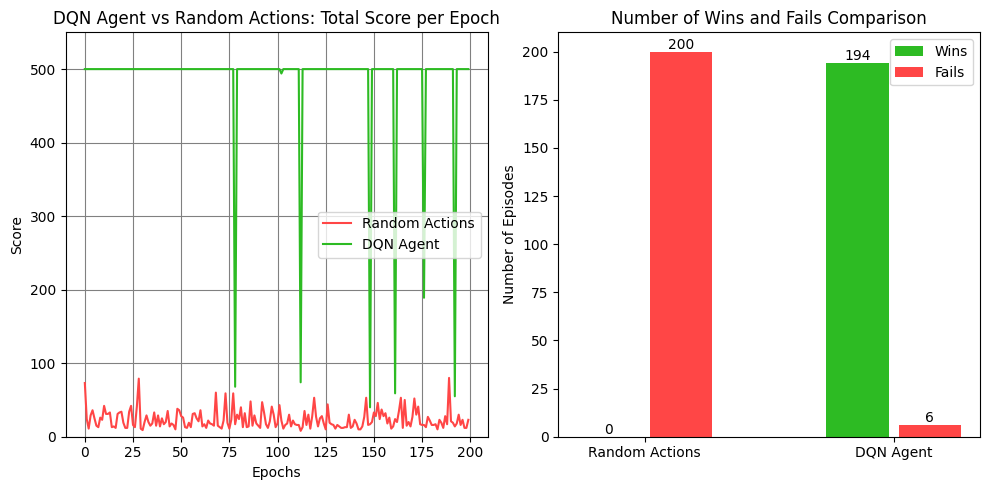

Number of wins with DQN Agent: 194
Number of fails with DQN Agent: 6


In [46]:
# Comparing the results between random actions and DQN agent
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(default_scores, label='Random Actions', color='#FF4646')
axis[0].plot(test_epochs_scores, label='DQN Agent', color='#2DBB23')

axis[0].set_ylim(0, 550)
axis[0].set_title("DQN Agent vs Random Actions: Total Score per Epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].legend()
axis[0].grid(color='grey')

categories = ['Random Actions', 'DQN Agent']
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
gap = 0.02

wins_values = [default_wins, dqn_wins]
fails_values = [default_fails, dqn_fails]

bars_wins = axis[1].bar(x - width/2 - gap, wins_values, width, label='Wins', color=["#2DBB23", '#2DBB23'])
bars_fails = axis[1].bar(x + width/2 + gap, fails_values, width, label='Fails', color=['#FF4646', '#FF4646'])

axis[1].set_title("Number of Wins and Fails Comparison")
axis[1].set_ylabel("Number of Episodes")
axis[1].set_xticks(x)
axis[1].set_xticklabels(categories)
axis[1].legend()

# Adding labels on top of the bars
for bar in bars_wins:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

for bar in bars_fails:
    height = bar.get_height()
    axis[1].text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(plots_save_path + 'dqn_vs_random.png')
plt.show()

print(f'Number of wins with DQN Agent: {dqn_wins}')
print(f'Number of fails with DQN Agent: {dqn_fails}')

In [50]:
sensitivity_study_results = run_sensitivity_study(experiments_params, DuelingArchitectureNetwork)


--- Sensitivity Study: Varying lr ---
Running experiment with lr = 0.0001
Running experiment with lr = 0.0005
Running experiment with lr = 0.001
Running experiment with lr = 0.005

--- Sensitivity Study: Varying gamma ---
Running experiment with gamma = 0.8
Running experiment with gamma = 0.9
Running experiment with gamma = 0.99
Running experiment with gamma = 0.999

--- Sensitivity Study: Varying replay_buffer_size ---
Running experiment with replay_buffer_size = 1000
Running experiment with replay_buffer_size = 5000
Running experiment with replay_buffer_size = 10000
Running experiment with replay_buffer_size = 50000

--- Sensitivity Study: Varying batch_size ---
Running experiment with batch_size = 32
Running experiment with batch_size = 64
Running experiment with batch_size = 128
Running experiment with batch_size = 256


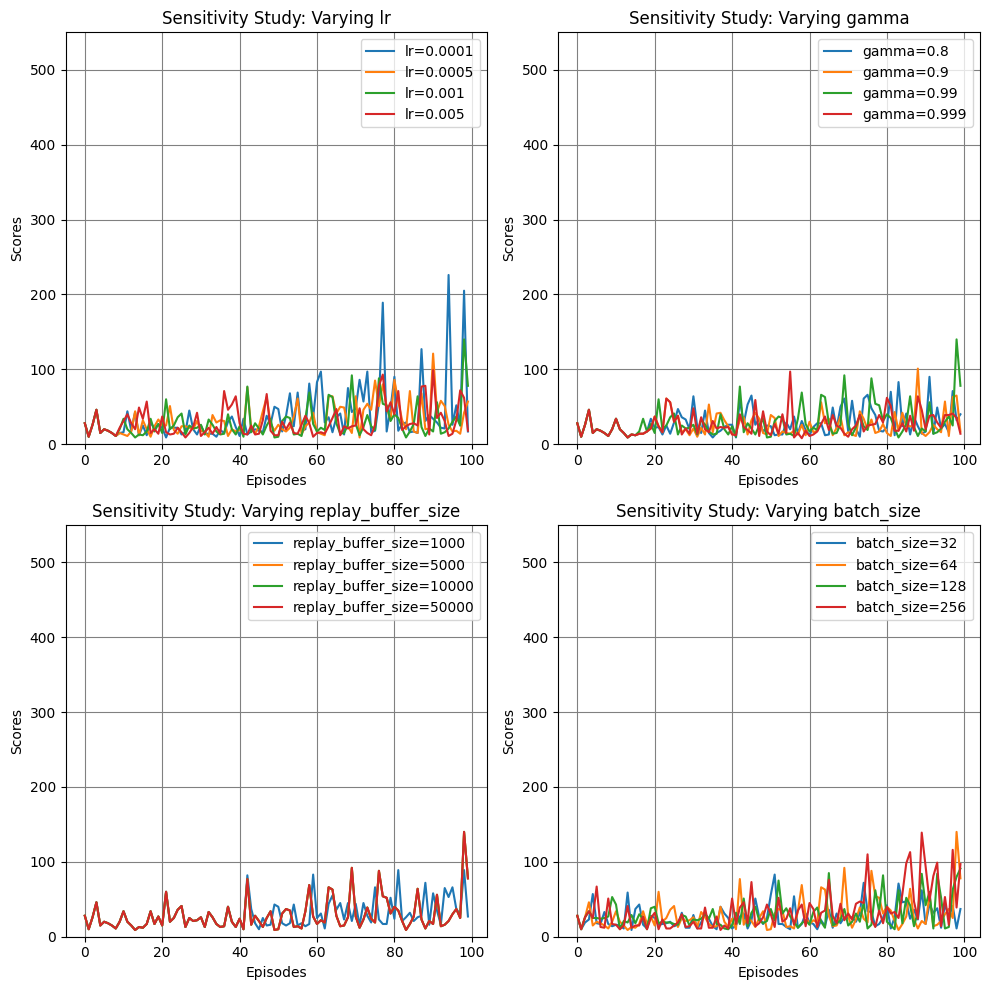

In [51]:
# Plot the sensitivity study results in a grid of 8x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for idx, (param, experiments) in enumerate(sensitivity_study_results.items()):
    for value, result in experiments.items():
        axes[idx].plot(result['scores'], label=f'{param}={value}')
    
    axes[idx].set_title(f'Sensitivity Study: Varying {param}')
    axes[idx].set_xlabel('Episodes')
    axes[idx].set_ylabel('Scores')
    axes[idx].set_ylim(0, 550)
    axes[idx].legend()
    axes[idx].grid(color='grey')

# Hide any unused subplots
for i in range(len(sensitivity_study_results), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(plots_save_path + 'sensitivity_study.png')
plt.show()